## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
from keras import regularizers

In [43]:
%pylab inline
import pandas as pd
import librosa
import glob 
from keras.callbacks import EarlyStopping

Populating the interactive namespace from numpy and matplotlib


C:\Users\20194998\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Link to dataset

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset

In [15]:
# Walking a directory tree and printing the names of the directories and files
mylist=[]
mydiclist={}
base_path='D:\\Projects\\ESA\Dataset\\Audio_Speech_Actors_01-24'
for dirpath, dirnames, files in os.walk(base_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            mydiclist[file_name]= dirpath
            mylist.append(file_name)

In [3]:
#from pathlib import Path
#curr_path = os.getcwd()
#crr_path = Path(curr_path)
#parent_path = crr_path.parent
#path = str(parent_path) +  '\\Actor_01\\'
#mylist= os.listdir(path)
#print(type(mylist))

## Setting the labels

In [16]:
feeling_list=[]
#for item in mylist:
#    if item[6:-16]=='03':
#        feeling_list.append('Happy')
#    elif item[6:-16]=='05':
#        feeling_list.append('Angry')
        
# (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).        
        
feeling_list=[]
for item in mylist:
    if item[6:-16]=='01':
        feeling_list.append('neutral')
    if item[6:-16]=='02':
        feeling_list.append('calm')
    elif item[6:-16]=='03':
        feeling_list.append('Happy')
    elif item[6:-16]=='04':
        feeling_list.append('sad')
    elif item[6:-16]=='05':
        feeling_list.append('angry')
    elif item[6:-16]=='06':
        feeling_list.append('fearful')
    elif item[6:-16]=='07': 
        feeling_list.append('disgust')
    elif item[6:-16]=='08': 
        feeling_list.append('surprised')
   

In [17]:
labels = pd.DataFrame(feeling_list)

In [18]:
labels[:]

,0
0,calm
1,neutral
2,neutral
3,neutral
4,neutral
...,...
1436,surprised
1437,surprised
1438,surprised
1439,surprised


## Getting the features of audio files using librosa

In [21]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    X, sample_rate = librosa.load(mydiclist[y]+'\\'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),
                        axis=0)
    feature = mfccs
    #[float(i) for i in feature]
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1    

In [ ]:
#df = pd.DataFrame(columns=['feature'])
#bookmark=0
#for index,y in enumerate(mylist):
#    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#        X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#        sample_rate = np.array(sample_rate)
#        mfccs = np.mean(librosa.feature.mfcc(y=X, 
#                                            sr=sample_rate, 
#                                            n_mfcc=13),
#                        axis=0)
#        feature = mfccs
#        #[float(i) for i in feature]
#        df.loc[bookmark] = [feature]
#        bookmark=bookmark+1        

In [22]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [23]:
newdf = pd.concat([df3,labels], axis=1)

In [24]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [25]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
299,-56.432880,-56.432880,-56.432880,-54.261124,-53.523640,-54.656101,-56.432880,-54.727272,-53.797302,-55.543869,...,-52.585335,-53.230957,-53.161907,-53.674191,-51.674911,-52.415932,-53.504013,-52.077087,-50.671516,surprised
886,-55.666416,-53.749599,-53.816616,-55.855381,-55.111858,-54.721279,-58.072712,-62.385109,-58.923027,-54.865944,...,-43.471531,-42.467476,-42.585106,-43.800571,-46.685684,-46.170086,-44.986694,-44.406681,-43.492863,disgust
414,-62.131100,-62.131100,-62.131100,-62.131100,-62.131100,-62.131100,-62.131100,-62.131100,-62.131100,-62.131100,...,-48.329693,-48.414902,-52.199959,-52.076439,-51.499275,-51.270329,-49.035549,-49.057579,-49.190536,surprised
979,-42.612175,-44.166237,-46.185036,-44.702591,-42.975323,-44.313457,-44.428078,-44.274414,-43.780632,-43.182182,...,-39.133873,-39.412003,-37.712002,-39.044552,-38.289963,-38.845627,-40.895973,-42.518826,-43.199871,Happy
1374,-52.935829,-53.834663,-54.324043,-53.665398,-54.501369,-55.804810,-55.343307,-56.418903,-57.266418,-56.669785,...,-56.989372,-56.058750,-55.534195,-55.383038,-57.237473,-58.036812,-58.112339,-58.031681,-56.773827,surprised
547,-52.358807,-51.610115,-50.046631,-49.424397,-51.406414,-51.462032,-50.192711,-51.117050,-52.238796,-51.404472,...,-48.206566,-49.825951,-48.717484,-47.780880,-49.512329,-49.161598,-46.813667,-46.451687,-45.739906,calm
353,-71.484970,-71.484970,-71.484970,-71.484970,-71.484970,-71.484970,-71.484970,-71.484970,-71.484970,-71.484970,...,-62.322880,-62.343601,-61.720432,-60.302925,-63.511345,-65.801910,-65.102058,-66.973267,-69.044624,surprised
1120,-45.133114,-45.986206,-47.102131,-47.071899,-50.197029,-50.810001,-50.140190,-50.094814,-52.950752,-53.276470,...,-51.100151,-50.897762,-50.474586,-49.177994,-48.331753,-49.057755,-47.925781,-48.229755,-51.377739,fearful
727,-57.304344,-57.513496,-57.424149,-60.285889,-63.514336,-59.822914,-59.655575,-60.264973,-60.922134,-63.632328,...,-66.580154,-65.908516,-65.687950,-59.147331,-57.582893,-60.386009,-62.520439,-63.540302,-65.164726,calm
333,-40.324867,-40.036160,-39.746658,-39.590351,-39.848934,-40.558823,-40.764133,-40.560123,-40.211590,-39.646713,...,-29.944859,-31.691959,-34.224365,-35.397488,-36.696175,-37.699234,-37.734016,-23.380659,-13.944887,angry


In [26]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [27]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [28]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
232,-53.852768,-53.852768,-53.852768,-53.852768,-53.852768,-53.852768,-53.852768,-53.852768,-53.852768,-53.852768,...,-42.638924,-42.770950,-44.072636,-44.311993,-44.131573,-44.608833,-46.935894,-48.826756,-50.628975,disgust
709,-51.506035,-53.286251,-54.424744,-52.822914,-52.119278,-54.102139,-55.346474,-54.710403,-52.439175,-52.182678,...,-29.572395,-30.520159,-30.141666,-31.015867,-33.825191,-33.527367,-32.418682,-32.458736,-31.829494,disgust
1127,-61.594719,-57.919277,-57.033695,-58.921162,-62.236286,-64.016373,-63.577663,-62.437687,-63.959393,-64.348763,...,-27.321072,-27.493065,-28.464296,-26.433481,-27.578749,-27.817707,-25.551094,-25.332052,-23.859333,disgust
1400,-52.388832,-52.388832,-52.388832,-52.388832,-54.024086,-54.198566,-53.286076,-52.388832,-52.388832,-52.399776,...,-44.524052,-46.362766,-46.383038,-47.492374,-51.348980,-51.252678,-50.509342,-49.606155,-47.599140,Happy
991,-57.586689,-56.086758,-53.829704,-53.242210,-51.507927,-49.827984,-49.511772,-50.775372,-54.970257,-57.406372,...,-46.774658,-49.279167,-47.368259,-48.282810,-48.861309,-49.222832,-53.694599,-53.383976,-52.556938,angry
736,-62.430161,-61.890205,-59.801773,-60.353928,-60.058758,-60.072021,-60.970772,-62.690819,-62.405861,-62.465813,...,-54.385944,-55.304020,-58.207424,-58.249245,-58.344139,-57.103432,-57.147392,-59.231651,-63.969559,Happy
1214,-54.912579,-53.479946,-50.805733,-51.206768,-53.265053,-56.825596,-57.514378,-57.514378,-55.364082,-53.777767,...,-39.919292,-41.233273,-43.230087,-43.495487,-46.043518,-46.545723,-49.342064,-50.947548,-49.810997,Happy
651,-55.618999,-56.453068,-55.836716,-56.042351,-55.994953,-55.355717,-55.054970,-54.578579,-55.100685,-57.088951,...,-39.368057,-41.021912,-44.416164,-43.697746,-44.673828,-48.692680,-49.427952,-48.472980,-46.734253,disgust
389,-56.991703,-56.940559,-57.108036,-57.278801,-57.235207,-57.340252,-56.768295,-57.140522,-56.035915,-56.392086,...,-20.153084,-19.958595,-18.861324,-16.960625,-17.121567,-17.872438,-18.308878,-19.673628,-20.240120,angry
943,-35.319462,-39.132694,-39.785702,-37.674015,-37.200958,-35.843155,-36.003845,-37.002804,-38.095699,-41.360298,...,-39.295048,-37.979324,-38.666508,-39.226162,-39.982407,-39.395073,-38.948021,-40.996468,-40.479919,fearful


In [29]:
trainfeatures = train.iloc[:, :-1]

In [30]:
trainlabel = train.iloc[:, -1:]
print(shape(trainlabel))

(1162, 1)


In [31]:
testfeatures = test.iloc[:, :-1]

In [32]:
testlabel = test.iloc[:, -1:]

In [33]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

nb_classes = 8 
encoder = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train), nb_classes)
y_test = np_utils.to_categorical(lb.fit_transform(y_test), nb_classes)

numpy.save('encoder.npy', lb.classes_)

C:\Users\20194998\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [34]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
X_train.shape

(1162, 216)

## Changing dimension for CNN model

In [37]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [81]:
model = Sequential()
#filters, kernel_size, strides=1, padding='valid', data_format='channels_last',

model.add(Conv1D(256, 5,padding='same', input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax')) #softmax as we are doing multiclass classification
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_5 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_6 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 27, 128)          

In [83]:
model.compile(loss=
             'categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
#tf.keras.losses.SparseCategoricalCrossentropy()
#'categorical_crossentropy'

In [90]:
#es = EarlyStopping(monitor='loss', mode='min')
#cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test), callbacks=[es])

In [92]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
73/73 [==============================] - 4s 55ms/step - loss: 1.3908 - accuracy: 0.4785 - val_loss: 1.6066 - val_accuracy: 0.4050
Epoch 2/200
73/73 [==============================] - 4s 55ms/step - loss: 1.3508 - accuracy: 0.5000 - val_loss: 1.5873 - val_accuracy: 0.4014
Epoch 3/200
 3/73 [>.............................] - ETA: 2s - loss: 1.1542 - accuracy: 0.6250

KeyboardInterrupt: 

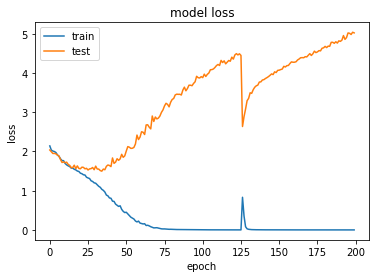

In [45]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [54]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\Projects\ESA\audio-sentiment-analysis\prototypes\saved_models\Emotion_Voice_Detection_Model.h5 


In [55]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [56]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 43.73%


## Predicting emotions on the test data

In [57]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

9/9 [==============================] - 0s 18ms/step


In [58]:
preds

array([[4.1288856e-01, 3.6293951e-01, 5.8791329e-15, ..., 1.7171131e-27,
        2.8766869e-03, 5.1190445e-12],
       [2.9769119e-02, 1.2676467e-04, 7.1895045e-10, ..., 6.9995987e-04,
        2.7670944e-02, 1.7470681e-08],
       [1.6386710e-07, 1.5108687e-11, 7.3987315e-03, ..., 2.5659572e-13,
        4.1134673e-01, 1.6568870e-07],
       ...,
       [1.6837008e-09, 1.2381636e-08, 6.5583740e-06, ..., 4.9442173e-21,
        1.6495692e-07, 3.6956369e-22],
       [1.5823890e-02, 8.1896985e-01, 1.0817103e-08, ..., 1.6807245e-04,
        9.0219365e-10, 1.9349322e-02],
       [8.5235088e-06, 9.9996114e-01, 1.2197758e-07, ..., 2.9652779e-22,
        3.0094106e-05, 2.9796356e-09]], dtype=float32)

In [59]:
preds1=preds.argmax(axis=1)

In [60]:
preds1

array([0, 4, 3, 2, 3, 7, 3, 7, 0, 6, 2, 5, 6, 4, 7, 3, 5, 0, 1, 7, 5, 6,
       7, 0, 6, 6, 6, 3, 4, 4, 3, 7, 2, 0, 5, 0, 0, 7, 6, 1, 6, 0, 4, 4,
       4, 3, 4, 3, 3, 6, 0, 3, 0, 6, 4, 5, 4, 6, 1, 0, 7, 6, 4, 2, 5, 6,
       1, 7, 2, 4, 0, 3, 0, 6, 5, 2, 4, 7, 0, 7, 6, 0, 4, 4, 1, 4, 7, 4,
       7, 0, 7, 4, 6, 2, 6, 4, 3, 1, 6, 5, 4, 2, 2, 1, 4, 5, 7, 1, 6, 6,
       3, 4, 0, 7, 3, 3, 5, 6, 7, 0, 0, 1, 1, 4, 3, 0, 3, 6, 4, 3, 2, 0,
       4, 0, 3, 2, 2, 4, 6, 1, 7, 6, 6, 3, 6, 7, 3, 3, 3, 7, 4, 5, 1, 0,
       2, 5, 6, 7, 6, 5, 7, 6, 4, 6, 0, 4, 1, 1, 1, 3, 6, 6, 6, 7, 4, 0,
       1, 3, 4, 6, 2, 7, 7, 0, 2, 0, 0, 1, 3, 7, 3, 7, 0, 6, 7, 4, 1, 6,
       7, 3, 2, 0, 1, 5, 7, 7, 4, 5, 0, 1, 2, 1, 4, 6, 3, 1, 6, 1, 0, 6,
       4, 6, 7, 4, 0, 3, 0, 4, 2, 5, 1, 6, 0, 6, 1, 4, 0, 7, 6, 7, 7, 3,
       4, 5, 7, 4, 1, 2, 7, 0, 6, 5, 4, 3, 6, 4, 4, 3, 7, 5, 5, 0, 3, 4,
       7, 5, 1, 2, 6, 3, 4, 7, 0, 3, 5, 1, 4, 1, 1], dtype=int64)

In [61]:
abc = preds1.astype(int).flatten()

In [62]:
predictions = (lb.inverse_transform((abc)))

In [63]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf

,predictedvalues
0,Happy
1,fearful
2,disgust
3,calm
4,disgust
...,...
274,neutral
275,angry
276,fearful
277,angry


In [64]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [65]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf

,actualvalues
0,disgust
1,fearful
2,disgust
3,sad
4,disgust
...,...
274,sad
275,surprised
276,calm
277,Happy


In [66]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [67]:
finaldf[0:4]

,actualvalues,predictedvalues
0,disgust,Happy
1,fearful,fearful
2,disgust,disgust
3,sad,calm


In [68]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
Happy,26
angry,40
calm,41
disgust,38
fearful,39
neutral,20
sad,37
surprised,38


In [69]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
Happy,39
angry,30
calm,20
disgust,36
fearful,46
neutral,22
sad,46
surprised,40


In [70]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

## you could find this track on below link:

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset%5Fsample%5Fprediction%5Ftracks

In [71]:
X, sample_rate = librosa.load(str(base_path) +'\\Recording_hateYou.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [72]:
livedf2= pd.DataFrame(data=livedf2)

In [73]:
livedf2 = livedf2.stack().to_frame().T

In [74]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-35.437946,-35.313591,-36.351669,-36.339912,-36.431698,-36.478317,-36.34008,-36.433208,-36.177975,-36.240341,...,-35.053753,-35.638748,-35.557884,-35.956326,-35.991673,-35.747616,-36.217129,-36.920151,-34.820885,-32.044918


In [75]:
twodim= np.expand_dims(livedf2, axis=2)

In [76]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 2ms/step


In [77]:
livepreds

array([[2.1903255e-05, 1.1687026e-11, 2.5173745e-19, 4.0671631e-18,
        1.4626336e-07, 0.0000000e+00, 2.0932359e-19, 9.9997795e-01]],
      dtype=float32)

In [78]:
livepreds1=livepreds.argmax(axis=1)

In [79]:
liveabc = livepreds1.astype(int).flatten()

In [80]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['surprised'], dtype=object)